# Utils

In [4]:
import numpy as np
from lib.data.metainfo import MetaInfo
from lib.data.transforms import BaseTransform
import hydra
from lib.utils.config import load_config
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from lib.data.transforms import BaseTransform, DilateSketch, ToSketch
from torchvision.transforms import v2


def plot_images_np(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image)
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images)
        plt.show()


def plot_images(images, size: int = 4):
    if isinstance(images, list):
        _, axes = plt.subplots(1, len(images), figsize=(size, size))
        for ax, image in zip(axes, images):
            ax.imshow(image.detach().cpu().numpy())
            ax.axis("off")  # Turn off axis
        plt.show()
    else:
        plt.figure(figsize=(size, size))
        plt.imshow(images.detach().cpu().numpy())
        plt.show()


cfg = load_config("optimize_sketch", ["+dataset=shapenet_chair_4096"])
metainfo = MetaInfo(cfg.data.data_dir)

cfg.model.prior_obj_id = metainfo.obj_ids[13]
cfg.model.loss_ckpt_path = "/home/borth/sketch2shape/checkpoints/latent_siamese_sketch_grayscale_latent_256.ckpt"
cfg.model.latent_init = "latent"

model = hydra.utils.instantiate(cfg.model).to("cuda")

# transforms
transforms = [v2.Resize((256, 256)), ToSketch(), DilateSketch(kernel_size=5)]
trans = BaseTransform(transforms=transforms)
to_image = BaseTransform(normalize=False, transforms=transforms)

In [9]:
model.deepsdf.create_camera(azim=10, elev=-20)
with torch.no_grad():
    points, surface_mask = model.deepsdf.sphere_tracing(
        latent=model.latent,
        points=model.deepsdf.camera_points,
        mask=model.deepsdf.camera_mask,
        rays=model.deepsdf.camera_rays,
    )
    normals = model.deepsdf.render_normals(
        points=points,
        latent=model.latent,
        mask=surface_mask,
    )
    grayscale = model.deepsdf.normals_to_grayscales(normals)
    silhouette = model.deepsdf.render_silhouette(
        normals=normals,
        points=points,
        latent=model.latent,
        proj_blur_eps=0.7,
        weight_blur_kernal_size=9,
        weight_blur_sigma=9.0,
    )
plot_images(
    [
        normals,
        silhouette["min_sdf"],
        silhouette["base_silhouette"],
        silhouette["extra_silhouette"],
        silhouette["proj_silhouette"],
        silhouette["proj_blur_silhouette"],
        silhouette["base_blur_silhouette"],
        silhouette["weighted_silhouette"],
        silhouette["final_silhouette"],
    ],
    size=32,
)

AttributeError: 'DeepSDF' object has no attribute 'normals_to_grayscales'

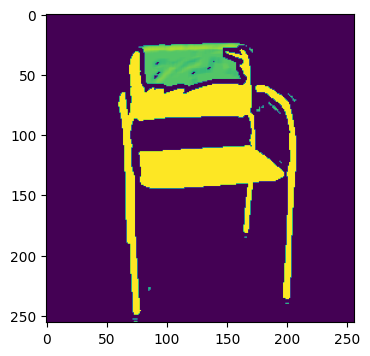

In [7]:
bbs = silhouette["base_blur_silhouette"].clone()
bbs[bbs > 1e-03] = 0.0
ws = silhouette["weighted_silhouette"].clone()
bs = silhouette["base_silhouette"].clone()
plot_images(torch.clip(bbs + ws + bs, 0, 1))

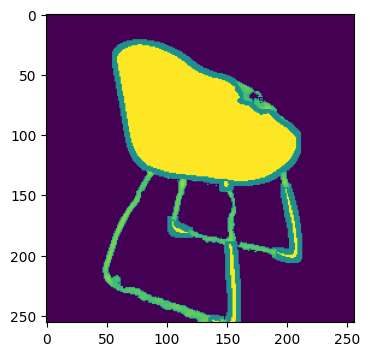

In [3]:
plot_images(silhouette["final_silhouette"])

# Silhouette Loss

/tmp/ipykernel_527919/3602237020.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sketch_input = model.deepsdf.image_to_siamese(torch.tensor(sketch).to("cuda"))


tensor([0.2279], device='cuda:0')


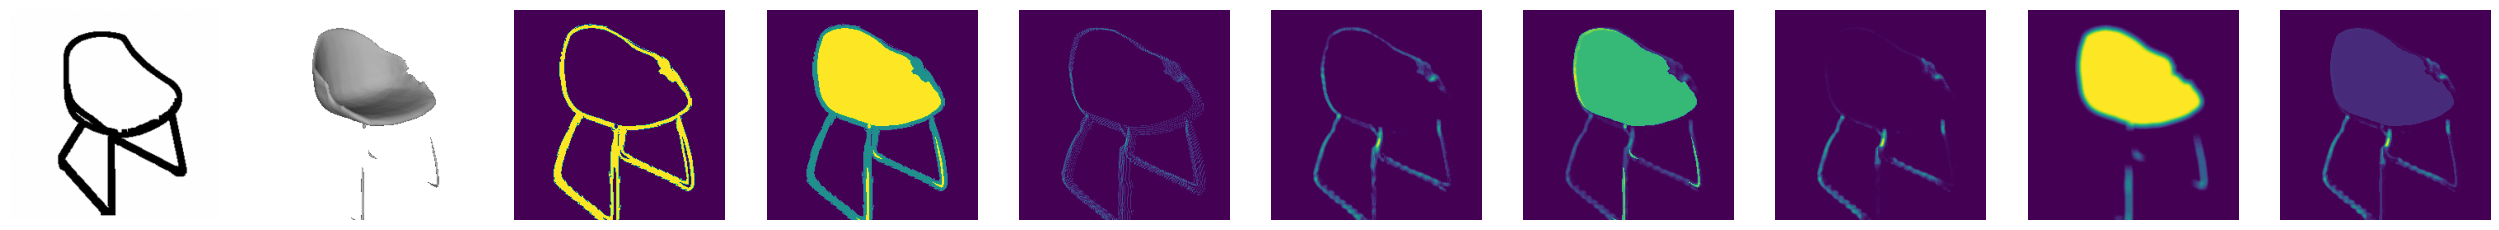

In [3]:
# 10, 4112, (4117), 12, 13, 4152
# obj_label = 4117
# obj_label = 4152
obj_label = 4112  # [1250,  585, 3916,  673]  4015
min_eps = 1e-03
max_eps = 5e-02
azim = 40
elev = -20
width = 256
height = 256
focal = 512

# get the sketch form the dataset
img = metainfo.load_image(obj_label, 11, 0)
sketch = trans(img)[None, ...].to("cuda")

# get the rendered normal
model.latent = model.loss.embedding(sketch, mode="sketch")[0]
model.deepsdf.hparams["surface_eps"] = min_eps
model.deepsdf.create_camera(azim=azim, elev=elev)
model.deepsdf.eval()
with torch.no_grad():
    points, surface_mask = model.deepsdf.sphere_tracing(
        latent=model.latent,
        points=model.deepsdf.camera_points,
        mask=model.deepsdf.camera_mask,
        rays=model.deepsdf.camera_rays,
    )
    image = model.deepsdf.render_grayscale(
        points=points,
        latent=model.latent,
        mask=surface_mask,
    )
rendered_normal = image.detach().cpu().numpy()
sketch, normal = to_image(img).permute(1, 2, 0), rendered_normal

normal_input = model.deepsdf.image_to_siamese(torch.tensor(normal).to("cuda"))
sketch_input = model.deepsdf.image_to_siamese(torch.tensor(sketch).to("cuda"))
normal_emb = model.loss.embedding(normal_input)
sketch_emb = model.loss.embedding(sketch_input)
loss = model.loss.compute(normal_emb, sketch_emb)
print(loss)

# silhouette information
min_sdf = torch.abs(model.forward(points)).reshape(width, height).detach().cpu()
min_points = points.reshape(width, height, 3).detach().cpu()
min_normals = ((image - 0.5) / 0.5).detach().cpu()
silhouette = ((min_sdf < max_eps) & (min_sdf > min_eps)).numpy().astype(np.uint8)


surface_mask = (
    surface_mask.reshape(width, height).detach().cpu().numpy().astype(np.uint8)
)


sil = torch.zeros_like(min_sdf)
w2c = model.deepsdf.world_to_camera.detach().cpu().to(torch.float32)
idx = np.where(silhouette)
w_points = min_points[idx] - min_normals[idx] * min_sdf[idx][..., None]

c_points = np.ones((w_points.shape[0], 4))
c_points[:, :3] = w_points
c_points = w2c @ c_points.T
c_points = c_points.T

pxs = ((width * 0.5) - (c_points[:, 0] * focal) / c_points[:, 2]).to(torch.int)
pys = ((height * 0.5) - (c_points[:, 1] * focal) / c_points[:, 2]).to(torch.int)

inside_mask = (pxs >= 0) & (pxs < width) & (pys >= 0) & (pys < height)
pxs = pxs[inside_mask]
pys = pys[inside_mask]

unique_idx, counts = torch.stack([pys, pxs]).unique(dim=1, return_counts=True)
sil[unique_idx[0], unique_idx[1]] = counts.to(torch.float32)

blur = v2.GaussianBlur(kernel_size=5, sigma=3.0)
sil_blur = blur(torch.stack([sil, sil, sil]))[0]
sil_blur = torch.clip(sil_blur - 0.5, min=0)

blur1 = v2.GaussianBlur(kernel_size=9, sigma=9)
in_blur = torch.tensor(
    np.stack([surface_mask, surface_mask, surface_mask]), dtype=torch.float32
)
s_mask = blur1(in_blur)[0]

weights = torch.clip(-torch.log(s_mask), 0, 10)
final_blur = sil_blur * weights

plot_images_np(
    [
        sketch,
        normal,
        silhouette,
        silhouette + surface_mask * 2,
        sil,
        sil_blur,
        sil_blur + surface_mask * 2,
        final_blur,
        s_mask,
        final_blur + surface_mask * 2,
    ],
    size=32,
)

# Neg Silhouette

In [ ]:
# 10, 4112, (4117), 12, 13, 4152
# obj_label = 4117
# obj_label = 4152
obj_label = 4016
min_eps = 1e-06
max_eps = 1e-03
azim = 30
elev = -20
width = 256
height = 256
focal = 512

# get the sketch form the dataset
img = metainfo.load_sketch(metainfo.obj_ids[obj_label], "00011")
sketch = trans(img)[None, ...].to("cuda")

# get the rendered normal
model.latent = model.loss.embedding(sketch, mode="sketch")[0]
model.deepsdf.hparams["surface_eps"] = min_eps
model.deepsdf.create_camera(azim=azim, elev=elev)
model.deepsdf.eval()
with torch.no_grad():
    points, surface_mask = model.deepsdf.sphere_tracing(
        latent=model.latent,
        points=model.deepsdf.camera_points,
        mask=model.deepsdf.camera_mask,
        rays=model.deepsdf.camera_rays,
    )
    image = model.deepsdf.render_grayscale(
        points=points,
        latent=model.latent,
        mask=surface_mask,
    )
rendered_normal = image.detach().cpu().numpy()
sketch, normal = to_image(img).permute(1, 2, 0), rendered_normal

normal_input = model.deepsdf.image_to_siamese(torch.tensor(normal).to("cuda"))
sketch_input = model.deepsdf.image_to_siamese(torch.tensor(sketch).to("cuda"))
normal_emb = model.loss.embedding(normal_input)
sketch_emb = model.loss.embedding(sketch_input)
loss = model.loss.compute(normal_emb, sketch_emb)
print(loss)

# silhouette information
min_sdf = torch.abs(model.forward(points)).reshape(width, height).detach().cpu()
min_points = points.reshape(width, height, 3).detach().cpu()
min_normals = ((image - 0.5) / 0.5).detach().cpu()
silhouette = ((min_sdf < max_eps) & (min_sdf > min_eps)).numpy().astype(np.uint8)


surface_mask = (
    surface_mask.reshape(width, height).detach().cpu().numpy().astype(np.uint8)
)


sil = torch.zeros_like(min_sdf)
w2c = model.deepsdf.world_to_camera.detach().cpu().to(torch.float32)
idx = np.where(silhouette)
w_points = min_points[idx] - min_normals[idx] * min_sdf[idx][..., None]

c_points = np.ones((w_points.shape[0], 4))
c_points[:, :3] = w_points
c_points = w2c @ c_points.T
c_points = c_points.T

pxs = ((width * 0.5) - (c_points[:, 0] * focal) / c_points[:, 2]).to(torch.int)
pys = ((height * 0.5) - (c_points[:, 1] * focal) / c_points[:, 2]).to(torch.int)

inside_mask = (pxs >= 0) & (pxs < width) & (pys >= 0) & (pys < height)
pxs = pxs[inside_mask]
pys = pys[inside_mask]

unique_idx, counts = torch.stack([pys, pxs]).unique(dim=1, return_counts=True)
sil[unique_idx[0], unique_idx[1]] = counts.to(torch.float32)

blur = v2.GaussianBlur(kernel_size=5, sigma=3.0)
sil_blur = blur(torch.stack([sil, sil, sil]))[0]
sil_blur = torch.clip(sil_blur - 0.5, min=0)

blur1 = v2.GaussianBlur(kernel_size=9, sigma=9)
in_blur = torch.tensor(
    np.stack([surface_mask, surface_mask, surface_mask]), dtype=torch.float32
)
s_mask = blur1(in_blur)[0]

weights = torch.clip(-torch.log(s_mask), 0, 10)
final_blur = sil_blur * weights

plot_images(
    [
        sketch,
        normal,
        silhouette,
        silhouette + surface_mask * 2,
        sil,
        sil_blur,
        sil_blur + surface_mask * 2,
        final_blur,
        final_blur + surface_mask * 2,
    ],
    size=32,
)

In [ ]:
min_sdf = torch.abs(model.forward(points))
silhouette = min_sdf.reshape(256, 256) < model.deepsdf.hparams["surface_eps"] * 50
plt.imshow(silhouette.detach().cpu().numpy())

In [ ]:
min_sdf = torch.abs(model.forward(points))
silhouette = min_sdf.reshape(256, 256) < model.deepsdf.hparams["surface_eps"] * 10
plt.imshow(silhouette.detach().cpu().numpy())

# Normals

In [ ]:
normals = model.deepsdf.render_normals(points, model.latent, model.deepsdf.camera_mask)
plot_images(normals.detach().cpu().numpy())
normals = (normals - 0.5) * 2  # IMPORTANT transform back to normal

In [ ]:
proj_points = (
    points.reshape(256, 256, 3) - normals * min_sdf.reshape(256, 256)[..., None]
)
(normals * min_sdf.reshape(256, 256)[..., None])[surface_mask.reshape(256, 256)]
intrinsic = torch.tensor(
    [
        [512, 0, 0],
        [0, 512, 0],
        [0, 0, 1],
    ]
).to(proj_points)
p = proj_points @ model.deepsdf.world_to_camera[:3, :3].T.float()
# p = (p @ intrinsic.T)[:, :, :2]

# i = np.zeros((256, 256))
# for x in tqdm(range(256)):
#     for y in range(256):
#         px = (p[:, :, 0] >= x) & (p[:, :, 0] <= x+1)
#         py = (p[:, :, 1] >= y) & (p[:, :, 1] <= y+1)
#         hit = bool((px & py).sum())
#         if hit:
#             i[x,y] = 1.0

from lib.render.camera import Camera

camera = Camera()
camera.get_camera_to_world() @ np.array([1, 0, 4, 1])
intrinsic = np.array(
    [
        [512, 0, 0],
        [0, 512, 0],
        [0, 0, 1],
    ]
)
intrinsic @ np.array([0, 0, 4])
256 * 0.5 - 128
# (0 - 256 * 0.5) / 512
# (0 - 256 * 0.5) / 512
128 + (512 * 1) / 4, 128 + (512 * 1) / 4